In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from picasso import STYLE_LAYERS, CONTENT_LAYERS
from cost_functions import *
from utils.misc_utils import *
from vgg.vgg_model import *
%matplotlib inline

2023-10-17 20:08:45.408065: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 20:08:46.415832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-17 20:08:48.180869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 20:08:48.282506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 20:08:48.282576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

1. Load VGG19 
2. Chose your style and content layers. Uncomment the top to list all layers

In [2]:
img_size = 512
vgg = get_model(img_size=img_size)

#for layer in vgg.layers:
#    print(layer.name)

INPUT_LAYERS = [(vgg.layers[0].name, 1)]

vgg_style_outputs = get_style_model(vgg)
vgg_model_content_outputs = get_content_model(vgg)
inputs_layer_output = get_layer_outputs(vgg, INPUT_LAYERS)

In [3]:
content_image, style_image, generated_image = load_images("images/sib.jpg", "images/monet.jpg", img_size=img_size)

In [4]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_content_outputs(preprocessed_content)
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_style_outputs(preprocessed_style)

#content_target = vgg_style_outputs(content_image)  # Content encoder
#style_targets = vgg_style_outputs(style_image)     # Style encoder

2023-10-17 20:08:52.967452: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-10-17 20:08:53.789353: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

#@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C

        
        # Compute a_G as the vgg_style_outputs for the current generated image
        #(1 line)
        a_G_s = vgg_style_outputs(generated_image)
        a_G_c = vgg_model_content_outputs(generated_image)
        
        # Getting the original image for denoising
        a_I = inputs_layer_output(generated_image)
        
        # Compute the style cost
        #(1 line)
        J_style = compute_style_cost(a_S, a_G_s, STYLE_LAYERS)
        
        #(2 lines)
        # Compute the content cost
        J_content = compute_content_cost(a_C,a_G_c)
        
        
        #J_noise = compute_noise_cost(a_I)
        J_noise = 0
        
        # Compute the total cost
        J = total_cost(J_content, J_style, J_noise, alpha = 4, beta = 4000, gamma = 0)
        
        ### END CODE HERE
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    #J_style = compute_style_cost(a_S, a_G_s, STYLE_LAYERS, layer_wise_output=True)
    # For grading purposes
    return J, J_style, J_content, J_noise

2023-10-17 20:08:54.881927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2023-10-17 20:08:56.482874: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xcc7069a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-17 20:08:56.482921: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-10-17 20:08:56.491793: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-17 20:08:56.553237: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-17 20:08:56.610627: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 0 with J: 5051.025390625, J_style: 1.2621817588806152, J_content: 0.5745579600334167, J_noise: 0


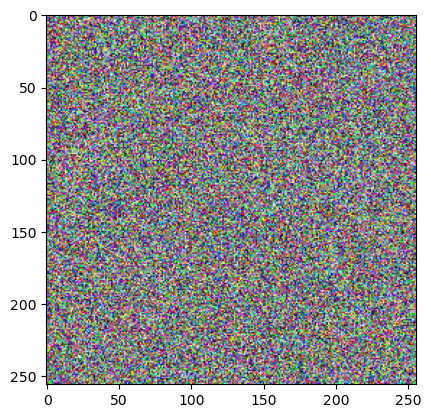

Epoch 25 with J: 2946.318359375, J_style: 0.7360302209854126, J_content: 0.5493854284286499, J_noise: 0
Epoch 50 with J: 2289.951171875, J_style: 0.5719685554504395, J_content: 0.519196093082428, J_noise: 0
Epoch 75 with J: 1821.65966796875, J_style: 0.454922080039978, J_content: 0.492825984954834, J_noise: 0
Epoch 100 with J: 1473.409912109375, J_style: 0.3678784966468811, J_content: 0.4739798903465271, J_noise: 0
Epoch 125 with J: 1210.8994140625, J_style: 0.3022654056549072, J_content: 0.45945653319358826, J_noise: 0
Epoch 150 with J: 1005.6347045898438, J_style: 0.25095945596694946, J_content: 0.4492250084877014, J_noise: 0
Epoch 175 with J: 839.0913696289062, J_style: 0.2093297392129898, J_content: 0.44310426712036133, J_noise: 0
Epoch 200 with J: 702.8319091796875, J_style: 0.17526866495609283, J_content: 0.4393197298049927, J_noise: 0
Epoch 225 with J: 591.3077392578125, J_style: 0.14739012718200684, J_content: 0.43681520223617554, J_noise: 0
Epoch 250 with J: 500.14874267578125

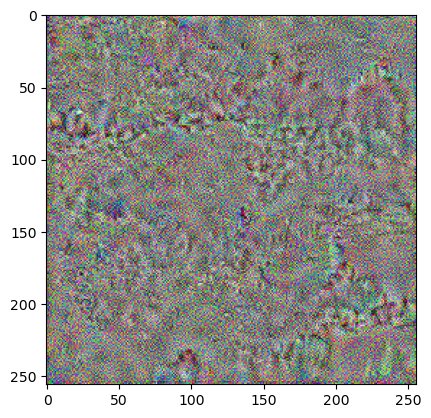

Epoch 525 with J: 135.38735961914062, J_style: 0.03341624140739441, J_content: 0.43059825897216797, J_noise: 0
Epoch 550 with J: 125.74506378173828, J_style: 0.03100593388080597, J_content: 0.4303313195705414, J_noise: 0
Epoch 575 with J: 117.45127868652344, J_style: 0.02893267571926117, J_content: 0.4301437735557556, J_noise: 0
Epoch 600 with J: 110.30125427246094, J_style: 0.027145521715283394, J_content: 0.42979177832603455, J_noise: 0
Epoch 625 with J: 104.11843872070312, J_style: 0.02559998258948326, J_content: 0.42962679266929626, J_noise: 0
Epoch 650 with J: 98.6840591430664, J_style: 0.024241596460342407, J_content: 0.42941856384277344, J_noise: 0
Epoch 675 with J: 93.87665557861328, J_style: 0.02303987555205822, J_content: 0.42928820848464966, J_noise: 0
Epoch 700 with J: 89.58172607421875, J_style: 0.021966129541397095, J_content: 0.42930248379707336, J_noise: 0
Epoch 725 with J: 85.71490478515625, J_style: 0.020999478176236153, J_content: 0.42924848198890686, J_noise: 0
Epoc

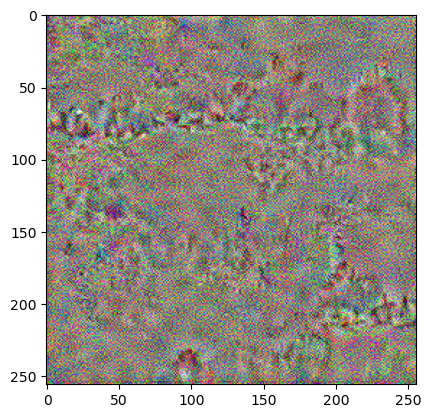

Epoch 1025 with J: 57.996612548828125, J_style: 0.014069193042814732, J_content: 0.42996031045913696, J_noise: 0
Epoch 1050 with J: 56.55443572998047, J_style: 0.013708671554923058, J_content: 0.4299371838569641, J_noise: 0
Epoch 1075 with J: 55.18018341064453, J_style: 0.013365143910050392, J_content: 0.42990216612815857, J_noise: 0
Epoch 1100 with J: 53.87388610839844, J_style: 0.013038720935583115, J_content: 0.42975059151649475, J_noise: 0
Epoch 1125 with J: 52.62856674194336, J_style: 0.012727536261081696, J_content: 0.4296053349971771, J_noise: 0
Epoch 1150 with J: 51.430118560791016, J_style: 0.01242800522595644, J_content: 0.42952466011047363, J_noise: 0
Epoch 1175 with J: 50.285736083984375, J_style: 0.012141965329647064, J_content: 0.42946958541870117, J_noise: 0
Epoch 1200 with J: 49.17849349975586, J_style: 0.01186518743634224, J_content: 0.4294360280036926, J_noise: 0
Epoch 1225 with J: 48.104129791259766, J_style: 0.011596603319048882, J_content: 0.42942875623703003, J_no

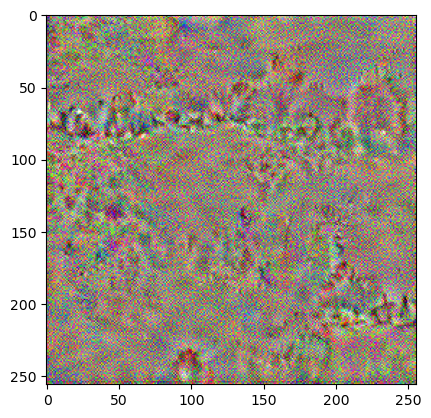

Epoch 1525 with J: 37.78764343261719, J_style: 0.009017852135002613, J_content: 0.4290589392185211, J_noise: 0
Epoch 1550 with J: 37.11067199707031, J_style: 0.008848658762872219, J_content: 0.42900991439819336, J_noise: 0
Epoch 1575 with J: 36.454139709472656, J_style: 0.008684463798999786, J_content: 0.42907190322875977, J_noise: 0
Epoch 1600 with J: 35.82049560546875, J_style: 0.008526003919541836, J_content: 0.42911988496780396, J_noise: 0
Epoch 1625 with J: 35.207672119140625, J_style: 0.00837282557040453, J_content: 0.4290924370288849, J_noise: 0
Epoch 1650 with J: 34.611083984375, J_style: 0.008223677054047585, J_content: 0.42909446358680725, J_noise: 0
Epoch 1675 with J: 34.034149169921875, J_style: 0.008079457096755505, J_content: 0.4290800988674164, J_noise: 0
Epoch 1700 with J: 33.47556686401367, J_style: 0.00793982483446598, J_content: 0.42906665802001953, J_noise: 0
Epoch 1725 with J: 32.93081283569336, J_style: 0.0078036244958639145, J_content: 0.4290786385536194, J_noise

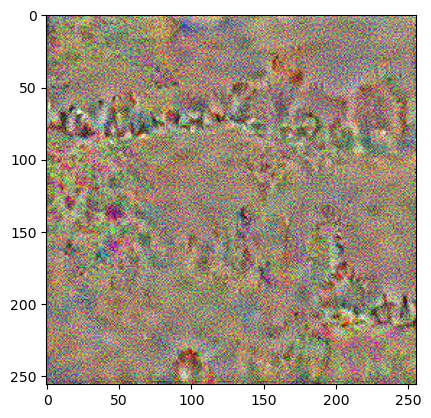

Epoch 2025 with J: 27.55938148498535, J_style: 0.006461179815232754, J_content: 0.4286655783653259, J_noise: 0
Epoch 2050 with J: 27.193302154541016, J_style: 0.00636967271566391, J_content: 0.42865288257598877, J_noise: 0
Epoch 2075 with J: 26.836666107177734, J_style: 0.006280527450144291, J_content: 0.42863887548446655, J_noise: 0
Epoch 2100 with J: 26.485986709594727, J_style: 0.0061928890645504, J_content: 0.42860764265060425, J_noise: 0
Epoch 2125 with J: 26.14333152770996, J_style: 0.006107225548475981, J_content: 0.4286075830459595, J_noise: 0
Epoch 2150 with J: 25.812362670898438, J_style: 0.006024494767189026, J_content: 0.4285958409309387, J_noise: 0
Epoch 2175 with J: 25.491003036499023, J_style: 0.0059441812336444855, J_content: 0.42856937646865845, J_noise: 0
Epoch 2200 with J: 25.180755615234375, J_style: 0.005866634659469128, J_content: 0.4285539388656616, J_noise: 0
Epoch 2225 with J: 24.875802993774414, J_style: 0.005790457129478455, J_content: 0.42849355936050415, J_

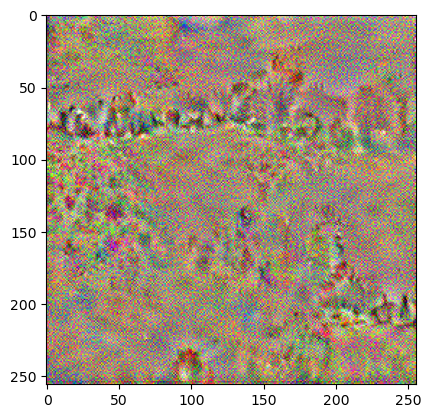

Epoch 2525 with J: 21.77685546875, J_style: 0.005017041694372892, J_content: 0.42717230319976807, J_noise: 0
Epoch 2550 with J: 21.556360244750977, J_style: 0.004962018225342035, J_content: 0.4270719587802887, J_noise: 0
Epoch 2575 with J: 21.341142654418945, J_style: 0.0049083037301898, J_content: 0.4269818365573883, J_noise: 0
Epoch 2600 with J: 21.129512786865234, J_style: 0.004855489823967218, J_content: 0.42688825726509094, J_noise: 0
Epoch 2625 with J: 20.92129135131836, J_style: 0.004803527612239122, J_content: 0.42679521441459656, J_noise: 0
Epoch 2650 with J: 20.718854904174805, J_style: 0.004753001034259796, J_content: 0.4267124533653259, J_noise: 0
Epoch 2675 with J: 20.519561767578125, J_style: 0.004703254904597998, J_content: 0.4266355633735657, J_noise: 0
Epoch 2700 with J: 20.3216495513916, J_style: 0.00465387012809515, J_content: 0.4265424907207489, J_noise: 0
Epoch 2725 with J: 20.127822875976562, J_style: 0.004605489782989025, J_content: 0.42646604776382446, J_noise: 

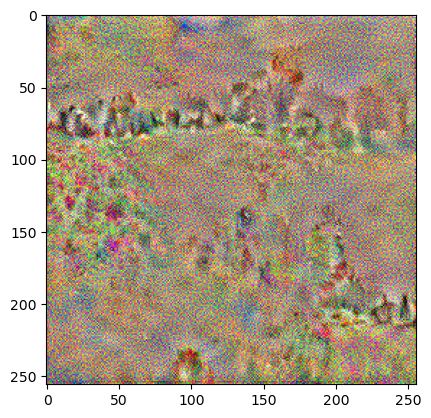

Epoch 3025 with J: 18.101459503173828, J_style: 0.004099637269973755, J_content: 0.4257277250289917, J_noise: 0
Epoch 3050 with J: 17.958322525024414, J_style: 0.004063923843204975, J_content: 0.4256569743156433, J_noise: 0
Epoch 3075 with J: 17.81890106201172, J_style: 0.00402910728007555, J_content: 0.42561835050582886, J_noise: 0
Epoch 3100 with J: 17.68243980407715, J_style: 0.003995067905634642, J_content: 0.4255422353744507, J_noise: 0
Epoch 3125 with J: 17.54806900024414, J_style: 0.003961535170674324, J_content: 0.425481915473938, J_noise: 0
Epoch 3150 with J: 17.417465209960938, J_style: 0.003928936552256346, J_content: 0.42542973160743713, J_noise: 0
Epoch 3175 with J: 17.28859519958496, J_style: 0.003896774724125862, J_content: 0.4253740906715393, J_noise: 0
Epoch 3200 with J: 17.161264419555664, J_style: 0.0038649877533316612, J_content: 0.42532819509506226, J_noise: 0
Epoch 3225 with J: 17.0374755859375, J_style: 0.003834103001281619, J_content: 0.4252656400203705, J_noise

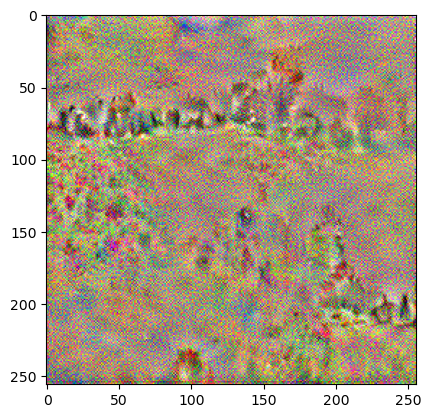

Epoch 3525 with J: 15.687604904174805, J_style: 0.0034975609742105007, J_content: 0.4243401288986206, J_noise: 0
Epoch 3550 with J: 15.586211204528809, J_style: 0.0034722727723419666, J_content: 0.4242800176143646, J_noise: 0
Epoch 3575 with J: 15.484475135803223, J_style: 0.003446867223829031, J_content: 0.4242515563964844, J_noise: 0
Epoch 3600 with J: 15.384086608886719, J_style: 0.0034218088258057833, J_content: 0.4242130517959595, J_noise: 0
Epoch 3625 with J: 15.286386489868164, J_style: 0.003397374413907528, J_content: 0.4242221415042877, J_noise: 0
Epoch 3650 with J: 15.189534187316895, J_style: 0.0033731567673385143, J_content: 0.4242267608642578, J_noise: 0
Epoch 3675 with J: 15.092550277709961, J_style: 0.003348979167640209, J_content: 0.4241582751274109, J_noise: 0
Epoch 3700 with J: 14.99634075164795, J_style: 0.0033249682746827602, J_content: 0.4241168797016144, J_noise: 0
Epoch 3725 with J: 14.90103530883789, J_style: 0.003301180200651288, J_content: 0.42407873272895813,

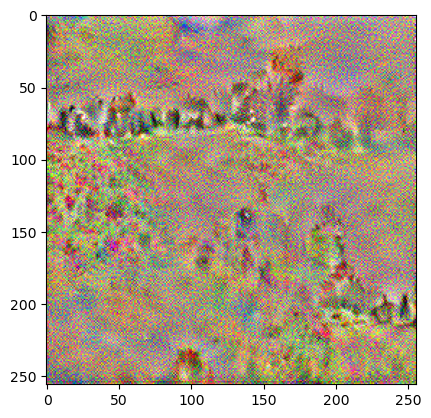

Epoch 4025 with J: 13.814033508300781, J_style: 0.003030058927834034, J_content: 0.4234495162963867, J_noise: 0
Epoch 4050 with J: 13.732648849487305, J_style: 0.0030097949784249067, J_content: 0.4233672320842743, J_noise: 0
Epoch 4075 with J: 13.652505874633789, J_style: 0.0029898465145379305, J_content: 0.4232800304889679, J_noise: 0
Epoch 4100 with J: 13.573174476623535, J_style: 0.002970060333609581, J_content: 0.423233300447464, J_noise: 0
Epoch 4125 with J: 13.495427131652832, J_style: 0.002950645051896572, J_content: 0.42321184277534485, J_noise: 0
Epoch 4150 with J: 13.418805122375488, J_style: 0.002931474708020687, J_content: 0.4232266843318939, J_noise: 0
Epoch 4175 with J: 13.342508316040039, J_style: 0.002912380499765277, J_content: 0.42324674129486084, J_noise: 0
Epoch 4200 with J: 13.267671585083008, J_style: 0.0028936518356204033, J_content: 0.4232662320137024, J_noise: 0
Epoch 4225 with J: 13.194713592529297, J_style: 0.002875383011996746, J_content: 0.42329537868499756

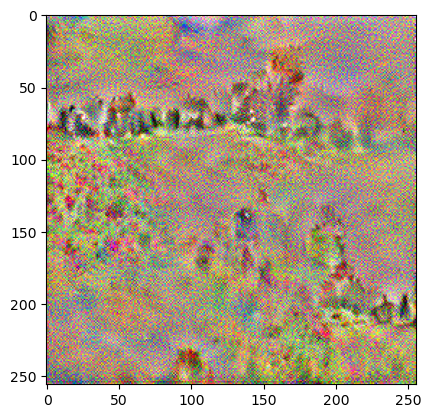

Epoch 4525 with J: 12.392022132873535, J_style: 0.002675046678632498, J_content: 0.42295894026756287, J_noise: 0
Epoch 4550 with J: 12.333616256713867, J_style: 0.002660471946001053, J_content: 0.4229322075843811, J_noise: 0
Epoch 4575 with J: 12.276824951171875, J_style: 0.0026463232934474945, J_content: 0.42288291454315186, J_noise: 0
Epoch 4600 with J: 12.220846176147461, J_style: 0.0026324079371988773, J_content: 0.422803670167923, J_noise: 0
Epoch 4625 with J: 12.165973663330078, J_style: 0.002618764527142048, J_content: 0.42272865772247314, J_noise: 0
Epoch 4650 with J: 12.111482620239258, J_style: 0.002605203539133072, J_content: 0.42266690731048584, J_noise: 0
Epoch 4675 with J: 12.058975219726562, J_style: 0.002592111937701702, J_content: 0.42263203859329224, J_noise: 0
Epoch 4700 with J: 12.007596969604492, J_style: 0.0025792913511395454, J_content: 0.4226079285144806, J_noise: 0
Epoch 4725 with J: 11.955554962158203, J_style: 0.002566282171756029, J_content: 0.42260634899139

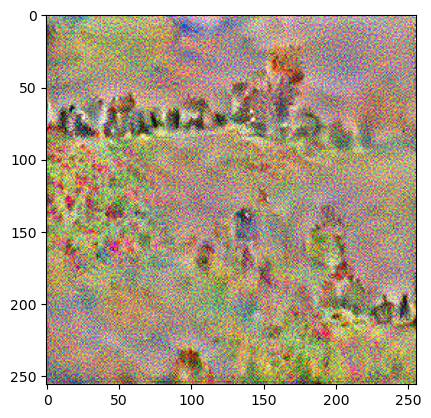

Epoch 5025 with J: 11.368729591369629, J_style: 0.002419823780655861, J_content: 0.4223584234714508, J_noise: 0
Epoch 5050 with J: 11.322591781616211, J_style: 0.0024083242751657963, J_content: 0.4223237633705139, J_noise: 0
Epoch 5075 with J: 11.276703834533691, J_style: 0.0023968915920704603, J_content: 0.4222843647003174, J_noise: 0
Epoch 5100 with J: 11.231244087219238, J_style: 0.002385561354458332, J_content: 0.4222494959831238, J_noise: 0
Epoch 5125 with J: 11.185382843017578, J_style: 0.002374126808717847, J_content: 0.4222187399864197, J_noise: 0
Epoch 5150 with J: 11.139841079711914, J_style: 0.002362774219363928, J_content: 0.42218613624572754, J_noise: 0
Epoch 5175 with J: 11.09444522857666, J_style: 0.0023514926433563232, J_content: 0.4221186637878418, J_noise: 0
Epoch 5200 with J: 11.050786972045898, J_style: 0.0023406497202813625, J_content: 0.42204707860946655, J_noise: 0
Epoch 5225 with J: 11.007322311401367, J_style: 0.0023298696614801884, J_content: 0.421960711479187

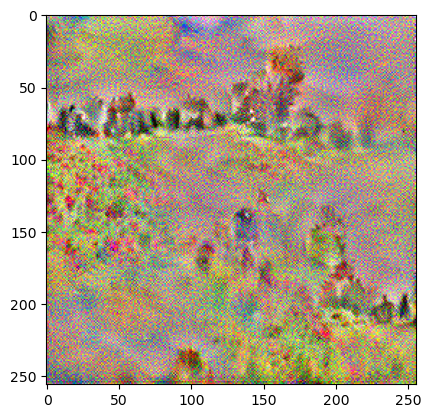

Epoch 5525 with J: 10.524601936340332, J_style: 0.0022098105400800705, J_content: 0.4213400185108185, J_noise: 0
Epoch 5550 with J: 10.485448837280273, J_style: 0.002200102200731635, J_content: 0.4212602376937866, J_noise: 0
Epoch 5575 with J: 10.44570255279541, J_style: 0.0021902103908360004, J_content: 0.421215295791626, J_noise: 0
Epoch 5600 with J: 10.4066162109375, J_style: 0.0021804911084473133, J_content: 0.42116281390190125, J_noise: 0
Epoch 5625 with J: 10.367668151855469, J_style: 0.002170783467590809, J_content: 0.4211335778236389, J_noise: 0
Epoch 5650 with J: 10.328962326049805, J_style: 0.002161135198548436, J_content: 0.42110541462898254, J_noise: 0
Epoch 5675 with J: 10.289251327514648, J_style: 0.0021512622479349375, J_content: 0.4210505187511444, J_noise: 0
Epoch 5700 with J: 10.249349594116211, J_style: 0.0021413173526525497, J_content: 0.4210200905799866, J_noise: 0
Epoch 5725 with J: 10.209514617919922, J_style: 0.0021313736215233803, J_content: 0.4210049510002136,

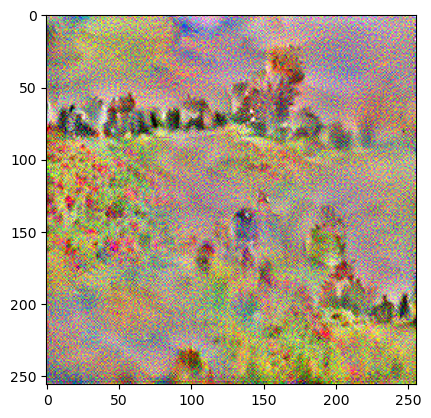

Epoch 6025 with J: 9.748603820800781, J_style: 0.0020167408511042595, J_content: 0.42041003704071045, J_noise: 0
Epoch 6050 with J: 9.712202072143555, J_style: 0.0020077263470739126, J_content: 0.4203239679336548, J_noise: 0
Epoch 6075 with J: 9.676512718200684, J_style: 0.00199886248447001, J_content: 0.4202657639980316, J_noise: 0
Epoch 6100 with J: 9.64128303527832, J_style: 0.0019900985062122345, J_content: 0.42022228240966797, J_noise: 0
Epoch 6125 with J: 9.605534553527832, J_style: 0.001981216249987483, J_content: 0.4201675057411194, J_noise: 0
Epoch 6150 with J: 9.570257186889648, J_style: 0.0019724364392459393, J_content: 0.42012786865234375, J_noise: 0
Epoch 6175 with J: 9.53506088256836, J_style: 0.00196370598860085, J_content: 0.4200592041015625, J_noise: 0
Epoch 6200 with J: 9.499897956848145, J_style: 0.0019549557473510504, J_content: 0.4200188219547272, J_noise: 0
Epoch 6225 with J: 9.464254379272461, J_style: 0.001946078147739172, J_content: 0.4199853837490082, J_noise:

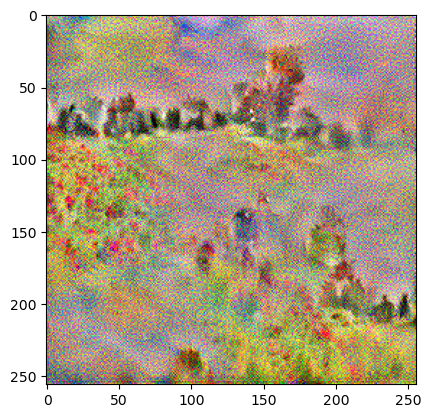

Epoch 6525 with J: 9.056967735290527, J_style: 0.001845095306634903, J_content: 0.41914665699005127, J_noise: 0
Epoch 6550 with J: 9.023125648498535, J_style: 0.001836738083511591, J_content: 0.41904327273368835, J_noise: 0
Epoch 6575 with J: 8.989285469055176, J_style: 0.0018283383687958121, J_content: 0.4189830422401428, J_noise: 0
Epoch 6600 with J: 8.954916000366211, J_style: 0.0018198253819718957, J_content: 0.4189035892486572, J_noise: 0
Epoch 6625 with J: 8.920980453491211, J_style: 0.0018114165868610144, J_content: 0.4188283681869507, J_noise: 0
Epoch 6650 with J: 8.887250900268555, J_style: 0.0018030456267297268, J_content: 0.41876697540283203, J_noise: 0
Epoch 6675 with J: 8.85335922241211, J_style: 0.001794640440493822, J_content: 0.4186994433403015, J_noise: 0
Epoch 6700 with J: 8.820158004760742, J_style: 0.001786412438377738, J_content: 0.4186271131038666, J_noise: 0
Epoch 6725 with J: 8.787300109863281, J_style: 0.0017782601062208414, J_content: 0.418565034866333, J_nois

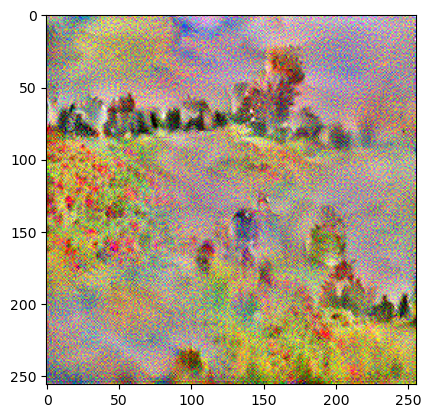

Epoch 7025 with J: 8.382131576538086, J_style: 0.0016776402480900288, J_content: 0.4178927540779114, J_noise: 0
Epoch 7050 with J: 8.349769592285156, J_style: 0.001669611781835556, J_content: 0.4178304672241211, J_noise: 0
Epoch 7075 with J: 8.318111419677734, J_style: 0.0016617231303825974, J_content: 0.41780465841293335, J_noise: 0
Epoch 7100 with J: 8.286805152893066, J_style: 0.001653893617913127, J_content: 0.4178076386451721, J_noise: 0
Epoch 7125 with J: 8.255422592163086, J_style: 0.0016460639890283346, J_content: 0.4177917242050171, J_noise: 0
Epoch 7150 with J: 8.224273681640625, J_style: 0.0016383156180381775, J_content: 0.4177526831626892, J_noise: 0
Epoch 7175 with J: 8.193136215209961, J_style: 0.0016305686440318823, J_content: 0.4177154302597046, J_noise: 0
Epoch 7200 with J: 8.161808967590332, J_style: 0.0016227785963565111, J_content: 0.4176735281944275, J_noise: 0
Epoch 7225 with J: 8.131009101867676, J_style: 0.0016150734154507518, J_content: 0.41767892241477966, J_n

KeyboardInterrupt: 

In [6]:
# Show the generated image at some epochs
# Uncomment to reset the style transfer process. You will need to compile the train_step function again 
epochs = 40000
for i in range(epochs):
    J, J_style, J_content, J_noise = train_step(generated_image)
    if i % 25 == 0:
        print(f"Epoch {i} with J: {J}, J_style: {J_style}, J_content: {J_content}, J_noise: {J_noise}")
        #for i, layer_cost in enumerate(J_style):
            #print(f"Layer {STYLE_LAYERS[i]} cost: {layer_cost}")
    if i % 500 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_test_{i}.jpg")
        plt.show() 

In [ ]:
a_G_s = vgg_style_outputs(generated_image)
J_style = compute_style_cost(a_S, a_G_s, STYLE_LAYERS, layer_wise_output=True)
for i, layer_cost in enumerate(J_style):
   print(f"Layer {STYLE_LAYERS[i]} cost: {layer_cost}")

print(tf.nn.softmax(J_style))

In [ ]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()